In [23]:
import os
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F

In [24]:
raw = pd.read_csv('../data/BTC/BTC_Book_0.zip', compression = 'zip', parse_dates = True, index_col = 0)
prices = raw[raw.columns[1::3]]
sizes = raw[raw.columns[2::3]]
trades = raw[raw.columns[3::3]]

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

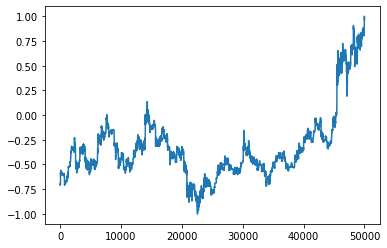

In [25]:
from sklearn.preprocessing import MinMaxScaler

price_scaler = MinMaxScaler(feature_range=(-1, 1))
mid_price = (prices['Bid_1_Price'] + prices['Ask_1_Price'])/2

mid_price_reshape = np.expand_dims(mid_price.values,1)
price_scaler.fit(mid_price_reshape)
mid_price_norm = price_scaler.transform(mid_price_reshape)
plt.plot(mid_price_norm.flatten())

#check proper scaling with data_min_

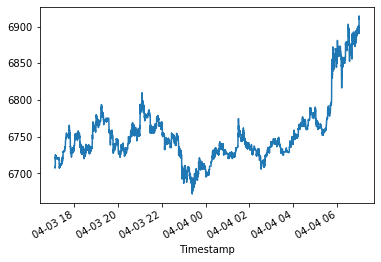

In [26]:
mid_price.plot()

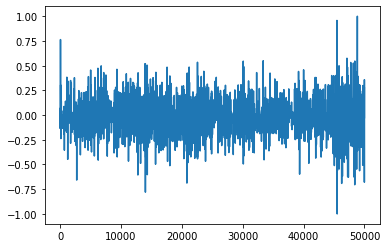

In [27]:
returns = mid_price.diff(1).dropna()
return_scaler = MinMaxScaler(feature_range=(-1,1))

returns_reshape = np.expand_dims(returns.values,1)
return_scaler.fit(returns_reshape)
returns_norm = return_scaler.transform(returns_reshape)
plt.plot(returns_norm.flatten())

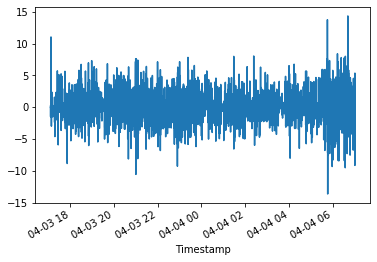

In [28]:
returns.plot()

In [29]:
subsets = rolling_window(mid_price_norm.flatten(),100)
X = subsets[:len(subsets)-1]
Y = subsets[1:]

X = torch.Tensor(np.expand_dims(X,2))
Y = torch.Tensor(np.expand_dims(Y,2))

print(X.shape)
print(Y.shape)

torch.Size([49900, 100, 1])
torch.Size([49900, 100, 1])


In [30]:
class RecurrentModel(nn.Module):
    def __init__(self, INPUT_SIZE, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE):
        super(RecurrentModel, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size = INPUT_SIZE,
            hidden_size = HIDDEN_SIZE, # number of hidden units
            num_layers = N_LAYERS, # number of layers
            batch_first = True
        )
        
        self.out = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)
            
    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        # r_out, (h_n, h_c) = self.rnn(x, None)
            
        r_out, h = self.lstm(x, None) # None represents zero initial hidden state
            
        # to choose last time step of output, use -1 in center index
            
        out = self.out(r_out[:, :, :])
        return out

    
n_hidden = 20
price_model = RecurrentModel(1, n_hidden, 1, 1)
return_model = RecurrentModel(1, n_hidden, 1, 1)

In [31]:
def train_model(model, LR, n_epochs, X_BATCH, Y_BATCH):
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)   # optimize all rnn parameters
    loss_func = nn.MSELoss()  

    all_losses = []
    all_accuracies = []

    for epoch in range(1,n_epochs+1):
        if epoch % 2 == 0:
            for param in optimizer.param_groups:
                param['lr'] = param['lr']/2 

        for i in range(len(X_BATCH)):

            train_x = X_BATCH[i]
            train_y = Y_BATCH[i]

            output = model(train_x)
            loss = loss_func(output, train_y)                # compute loss                      
            optimizer.zero_grad()                            # clear gradients for this training step
            loss.backward()                                  # backpropagation, compute gradients
            optimizer.step()                                 # apply gradient step

            all_losses.append(loss.item())                   #track loss

    #     #compute accuracy
    #     acc_output = rnn(b_x)
    #     pred_y = torch.max(acc_output,1)[1].data.numpy().squeeze()
    #     target = torch.max(b_y,1)[1].data.numpy().squeeze()
    #     train_accuracy = sum(pred_y==target)/b_y.size(0)

            #print info
            print("Epoch: ", epoch, "| train loss: %.4f" % loss.item())#, "| train accuracy: %.8f" % train_accuracy)

    return all_losses, all_accuracies

Epoch:  1 | train loss: 0.1601
Epoch:  1 | train loss: 0.0318
Epoch:  1 | train loss: 0.0435
Epoch:  1 | train loss: 0.0051
Epoch:  1 | train loss: 0.0076
Epoch:  1 | train loss: 0.0082
Epoch:  1 | train loss: 0.0041
Epoch:  1 | train loss: 0.0102
Epoch:  1 | train loss: 0.0034
Epoch:  1 | train loss: 0.0101
Epoch:  1 | train loss: 0.0009
Epoch:  1 | train loss: 0.0008
Epoch:  1 | train loss: 0.0386
Epoch:  1 | train loss: 0.0649
Epoch:  1 | train loss: 0.0470
Epoch:  1 | train loss: 0.0690
Epoch:  1 | train loss: 0.0096
Epoch:  1 | train loss: 0.0039
Epoch:  1 | train loss: 0.0516
Epoch:  1 | train loss: 0.1260
Epoch:  1 | train loss: 0.0966
Epoch:  1 | train loss: 0.1182
Epoch:  1 | train loss: 0.0730
Epoch:  1 | train loss: 0.0512
Epoch:  1 | train loss: 0.0042
Epoch:  1 | train loss: 0.0088
Epoch:  1 | train loss: 0.0076
Epoch:  1 | train loss: 0.0164
Epoch:  1 | train loss: 0.1581
Epoch:  1 | train loss: 0.1054
Epoch:  1 | train loss: 0.0863
Epoch:  1 | train loss: 0.0327
Epoch:  

Epoch:  3 | train loss: 0.0048
Epoch:  3 | train loss: 0.0022
Epoch:  3 | train loss: 0.0022
Epoch:  3 | train loss: 0.0013
Epoch:  3 | train loss: 0.0038
Epoch:  3 | train loss: 0.0080
Epoch:  3 | train loss: 0.0061
Epoch:  3 | train loss: 0.0046
Epoch:  3 | train loss: 0.0004
Epoch:  3 | train loss: 0.0004
Epoch:  3 | train loss: 0.0005
Epoch:  3 | train loss: 0.0003
Epoch:  3 | train loss: 0.0005
Epoch:  3 | train loss: 0.0004
Epoch:  3 | train loss: 0.0010
Epoch:  3 | train loss: 0.0012
Epoch:  3 | train loss: 0.0007
Epoch:  3 | train loss: 0.0008
Epoch:  3 | train loss: 0.0010
Epoch:  3 | train loss: 0.0010
Epoch:  3 | train loss: 0.0019
Epoch:  3 | train loss: 0.0028
Epoch:  3 | train loss: 0.0037
Epoch:  3 | train loss: 0.0013
Epoch:  3 | train loss: 0.0011
Epoch:  3 | train loss: 0.0029
Epoch:  3 | train loss: 0.0038
Epoch:  3 | train loss: 0.0037
Epoch:  3 | train loss: 0.0027
Epoch:  3 | train loss: 0.0030
Epoch:  3 | train loss: 0.0043
Epoch:  3 | train loss: 0.0036
Epoch:  

Epoch:  6 | train loss: 0.0010
Epoch:  6 | train loss: 0.0009
Epoch:  6 | train loss: 0.0007
Epoch:  6 | train loss: 0.0008
Epoch:  6 | train loss: 0.0008
Epoch:  6 | train loss: 0.0007
Epoch:  6 | train loss: 0.0007
Epoch:  6 | train loss: 0.0006
Epoch:  6 | train loss: 0.0005
Epoch:  6 | train loss: 0.0005
Epoch:  6 | train loss: 0.0006
Epoch:  6 | train loss: 0.0041
Epoch:  6 | train loss: 0.0140
Epoch:  6 | train loss: 0.0130
Epoch:  6 | train loss: 0.0194
Epoch:  6 | train loss: 0.0341
Epoch:  6 | train loss: 0.0137
Epoch:  6 | train loss: 0.0035
Epoch:  6 | train loss: 0.0016
Epoch:  6 | train loss: 0.0050
Epoch:  6 | train loss: 0.0053
Epoch:  6 | train loss: 0.0005
Epoch:  6 | train loss: 0.0018
Epoch:  6 | train loss: 0.0025
Epoch:  6 | train loss: 0.0037
Epoch:  6 | train loss: 0.0034
Epoch:  6 | train loss: 0.0028
Epoch:  6 | train loss: 0.0024
Epoch:  6 | train loss: 0.0021
Epoch:  6 | train loss: 0.0028
Epoch:  6 | train loss: 0.0037
Epoch:  6 | train loss: 0.0031
Epoch:  

Epoch:  8 | train loss: 0.0022
Epoch:  8 | train loss: 0.0025
Epoch:  8 | train loss: 0.0021
Epoch:  8 | train loss: 0.0024
Epoch:  8 | train loss: 0.0035
Epoch:  9 | train loss: 0.0001
Epoch:  9 | train loss: 0.0001
Epoch:  9 | train loss: 0.0001
Epoch:  9 | train loss: 0.0005
Epoch:  9 | train loss: 0.0007
Epoch:  9 | train loss: 0.0004
Epoch:  9 | train loss: 0.0005
Epoch:  9 | train loss: 0.0007
Epoch:  9 | train loss: 0.0006
Epoch:  9 | train loss: 0.0003
Epoch:  9 | train loss: 0.0004
Epoch:  9 | train loss: 0.0004
Epoch:  9 | train loss: 0.0007
Epoch:  9 | train loss: 0.0010
Epoch:  9 | train loss: 0.0011
Epoch:  9 | train loss: 0.0014
Epoch:  9 | train loss: 0.0011
Epoch:  9 | train loss: 0.0011
Epoch:  9 | train loss: 0.0007
Epoch:  9 | train loss: 0.0005
Epoch:  9 | train loss: 0.0006
Epoch:  9 | train loss: 0.0003
Epoch:  9 | train loss: 0.0004
Epoch:  9 | train loss: 0.0003
Epoch:  9 | train loss: 0.0007
Epoch:  9 | train loss: 0.0008
Epoch:  9 | train loss: 0.0007
Epoch:  

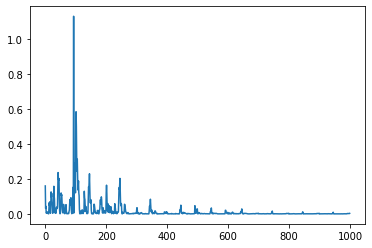

In [32]:
losses, accuracies = train_model(price_model, 
                                 LR=0.05, 
                                 n_epochs=10, 
                                 X_BATCH = np.split(X,100), 
                                 Y_BATCH = np.split(Y, 100)
                                )

plt.plot(losses)

In [33]:
out = price_model(X)
out_np = out.detach().numpy().squeeze()

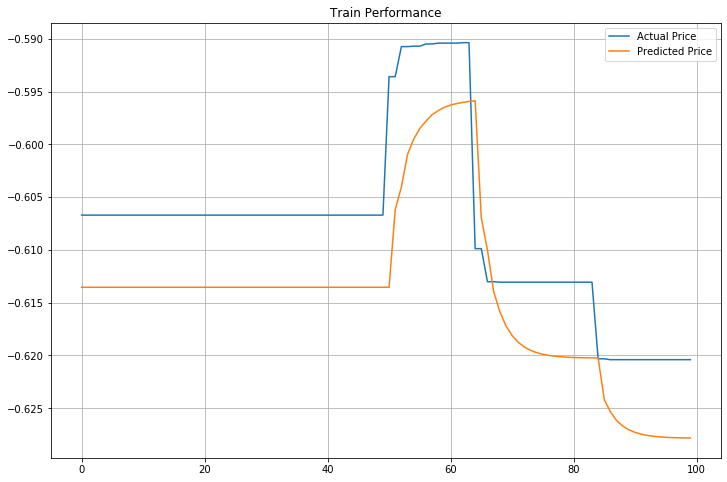

In [34]:
start = 500
window = 100

fig, ax = plt.subplots(1,1, figsize = (12,8))
ax.plot(mid_price_norm.flatten()[start + 100:start + 100 + window])
ax.plot(out_np[:,-1][start:start + window])

ax.set_title('Train Performance')
ax.legend(['Actual Price','Predicted Price'])
ax.grid('on')

In [36]:
#### TEST

raw = pd.read_csv('../data/BTC/BTC_Book_1.zip', compression = 'zip', parse_dates = True, index_col = 0)
prices = raw[raw.columns[1::3]]
sizes = raw[raw.columns[2::3]]
trades = raw[raw.columns[3::3]]

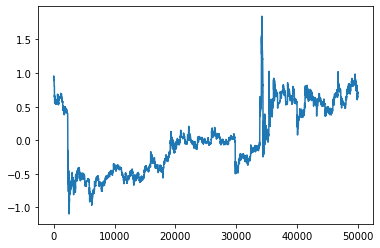

In [37]:
mid_price = (prices['Bid_1_Price'] + prices['Ask_1_Price'])/2

mid_price_reshape = np.expand_dims(mid_price.values,1)


mid_price_norm = price_scaler.transform(mid_price_reshape)

plt.plot(mid_price_norm.flatten())

In [38]:
subsets = rolling_window(mid_price_norm.flatten(),100)
X = subsets[:len(subsets)-1]
X = torch.Tensor(np.expand_dims(X,2))
print(X.shape)

torch.Size([49900, 100, 1])


In [39]:
out = price_model(X)
out_np = out.detach().numpy().squeeze()

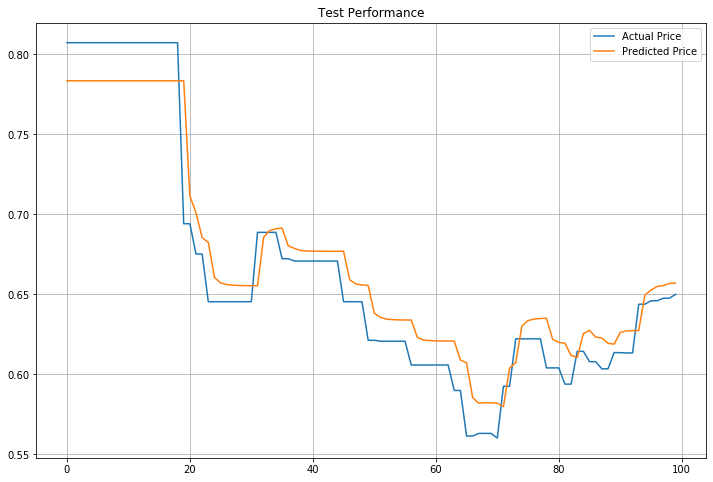

In [40]:
start = 0
window = 100

fig, ax = plt.subplots(1,1, figsize = (12,8))
ax.plot(mid_price_norm.flatten()[start + 100:start + 100 + window])
ax.plot(out_np[:,-1][start:start + window])

ax.set_title('Test Performance')
ax.legend(['Actual Price','Predicted Price'])
ax.grid('on')

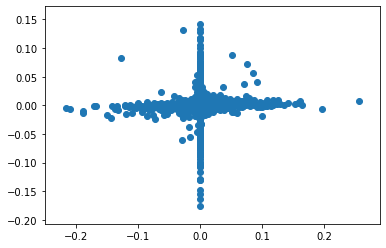

In [41]:
x = np.diff(mid_price_norm.flatten()[100:])
y = np.diff(out_np[:,-1])
plt.scatter(x,y)